# Regularization / Prior Analysis

---

In [12]:
import os
import numpy as np
import pynoisy
import xarray as xr
from pynoisy.inverse import *
from pynoisy import utils
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

In [32]:
def compute_gradient(solver, forward, adjoint, dx=1e-2):
    principle_angle = solver.diffusion.principle_angle.copy()
    source = solver.get_laplacian(forward)
    gradient = np.zeros(shape=solver.params.num_unknowns)
    for n, (i, j) in enumerate(zip(*np.where(solver.params.mask))):
        solver.diffusion.principle_angle[i, j] = principle_angle[i, j] + dx
        source_ij = solver.get_laplacian(forward) - source
        solver.diffusion.principle_angle[i, j] = principle_angle[i, j]
        source_ij = source_ij / dx
        gradient[n] += (adjoint * source_ij).mean()
    return gradient

def set_state(solver, state):
    solver.diffusion.principle_angle.values[solver.params.mask] = state
    
def set_disk_mask(solver):
    solver.params['mask'] = solver.params.r < 0.5 - 2.0 / solver.params.dims['x']
    solver.params.attrs['num_unknowns'] = solver.params.mask.sum().data
    return solver

## Generate / Load solver and measurements

### Generate

In [3]:
advection_true = pynoisy.advection.disk()
diffusion_true = pynoisy.diffusion.multivariate_gaussian(length_scale=0.1)
diffusion_true.diffusion_coefficient[:] = 1.0

Sampling diffusion principle angle from a multivariate gaussian (Matern covariance kernel size = 4096x4096)
Sampling correlation time from a multivariate gaussian (Matern covariance kernel size = 4096x4096)
Sampling diffusion coefficient from a multivariate gaussian (Matern covariance kernel size = 4096x4096)


In [11]:
solver = pynoisy.forward.NoisySolver(advection_true, diffusion_true)
solver.save(path=os.path.join(logdir, 'ground_truth.nc'))
measurements = solver.run_symmetric()
measurements.to_netcdf(os.path.join(logdir, 'measurements.nc'))

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.15it/s]


### Load

In [33]:
# Load measurements and solver
load_path = '../runs/symmetry_check/const_coef1.0/'
measurements = xr.load_dataarray(os.path.join(load_path,'measurements.nc'))
solver = pynoisy.forward.NoisySolver.from_netcdf(os.path.join(load_path, 'ground_truth.nc'))

solver = set_disk_mask(solver)
initial_state = np.zeros(shape=solver.params.num_unknowns)

forward_fn = lambda source: solver.run_symmetric(source, verbose=False)
adjoint_fn = lambda source: solver.run_adjoint(source, verbose=False)
gradient_fn = lambda forward, adjoint: compute_gradient(solver, forward, adjoint)
get_state_fn = lambda: solver.diffusion.principle_angle.values[solver.params.mask]
set_state_fn = lambda state: set_state(solver, state)

## Krylov Projected Measurements

### Prior

In [5]:
%%capture
krylov_degree = 8
projection_degree = 8
prior_weights = [1e-7, 1e-8, 1e-9]

def run_optimization(krylov_degree, projection_degree, solver, measurements, prior):
    run_name = 'krylov{}_projected{}_prior{}'.format(krylov_degree, projection_degree, prior)
    logdir = os.path.join('../runs/symmetry_check/', run_name)

    forward_op = ForwardOperator.krylov(
        forward_fn=forward_fn,
        adjoint_fn=adjoint_fn,
        gradient_fn=gradient_fn,
        set_state_fn=set_state_fn,
        get_state_fn=get_state_fn,
        measurements=measurements,
        degree=projection_degree)
    measurements = forward_op(forward_op.get_state())
    forward_op = ForwardOperator.krylov(
        forward_fn=forward_fn,
        adjoint_fn=adjoint_fn,
        gradient_fn=gradient_fn,
        set_state_fn=set_state_fn,
        get_state_fn=get_state_fn,
        measurements=measurements,
        degree=krylov_degree)
    objective_fn = ObjectiveFunction.l2(measurements, forward_op)
    
    # Define prior
    flat_mask = np.array(solver.params.mask).ravel()
    covariance_mask = np.dot(flat_mask[:, None], flat_mask[None])
    cov = solver.diffusion.covariance.values[covariance_mask].reshape(
        solver.params.num_unknowns, solver.params.num_unknowns)
    prior_fn = PriorFunction.mahalanobis(mean=0.0, cov=cov, scale=prior)
    loss_callback_fn = CallbackFn(
        lambda: writer.add_scalars(
            'Loss', {'total': objective_fn.loss + prior_fn.loss, 
                     'datafit': objective_fn.loss, 
                     'prior': prior_fn.loss}, optimizer.iteration)
    )
        
    writer = SummaryWriter(logdir=logdir)
    writer.average_image('average_frame/measurements', measurements)
    writer.diffusion('diffusion/true', solver.diffusion, solver.params.mask)
    callback_fn = [
        loss_callback_fn,
        CallbackFn(lambda: writer.add_scalar('Loss', objective_fn.loss, optimizer.iteration)),
        CallbackFn(lambda: writer.diffusion('diffusion/estimate', solver.diffusion, solver.params.mask, optimizer.iteration)),
        CallbackFn(lambda: optimizer.save_checkpoint(solver, logdir), ckpt_period=1*60*60)]
    options={'maxiter': 10000, 'maxls': 100, 'disp': True, 'gtol': 1e-16, 'ftol': 1e-16}
    optimizer = Optimizer(objective_fn, callback_fn=callback_fn, prior_fn=prior_fn, options=options)
    result = optimizer.minimize(initial_state=initial_state)
    optimizer.save_checkpoint(solver, logdir, name='final_result.nc')
    writer.close()
    
Parallel(n_jobs=len(prior_weights))(delayed(run_optimization)(
    krylov_degree, projection_degree, solver, measurements, prior) for prior in prior_weights)

### No prior

In [15]:
%%capture
krylov_degree = 8
projection_degree = 8

forward_op = ForwardOperator.krylov(
    forward_fn=forward_fn,
    adjoint_fn=adjoint_fn,
    gradient_fn=gradient_fn,
    set_state_fn=set_state_fn,
    get_state_fn=get_state_fn,
    measurements=measurements,
    degree=projection_degree)
measurements = forward_op(forward_op.get_state())

run_name = 'krylov{}_projected{}'.format(krylov_degree, projection_degree)
logdir = os.path.join('../runs/symmetry_check/', run_name)

forward_op = ForwardOperator.krylov(
    forward_fn=forward_fn,
    adjoint_fn=adjoint_fn,
    gradient_fn=gradient_fn,
    set_state_fn=set_state_fn,
    get_state_fn=get_state_fn,
    measurements=measurements,
    degree=krylov_degree)

objective_fn = ObjectiveFunction.l2(measurements, forward_op)
writer = SummaryWriter(logdir=logdir)
writer.average_image('average_frame/measurements', measurements)
writer.diffusion('diffusion/true', solver.diffusion, solver.params.mask)
callback_fn = [
    CallbackFn(lambda: writer.add_scalar('Loss', objective_fn.loss, optimizer.iteration)),
    CallbackFn(lambda: writer.diffusion('diffusion/estimate', solver.diffusion, solver.params.mask, optimizer.iteration)),
    CallbackFn(lambda: optimizer.save_checkpoint(solver, logdir), ckpt_period=1*60*60)]
options={'maxiter': 10000, 'maxls': 100, 'disp': True, 'gtol': 1e-16, 'ftol': 1e-16}
optimizer = Optimizer(objective_fn, callback_fn=callback_fn, options=options)
result = optimizer.minimize(initial_state=initial_state)
optimizer.save_checkpoint(solver, logdir, name='final_result.nc')
writer.close()

## Original Measurements


This cell checks if breaking the symmetry of **ALL** the diffusion fields breaks the error symmetry around the center

### No prior

In [ ]:
%%capture

krylov_degree = 8
run_name = 'const_coef5.0'
logdir = os.path.join('../runs/symmetry_check/', run_name)
writer = SummaryWriter(logdir=logdir)

# Save measurements and solver 
solver.diffusion.diffusion_coefficient[:] = 5.0
measurements = solver.run_symmetric()
measurements.to_netcdf(os.path.join(logdir, 'measurements.nc'))
solver.save(path=os.path.join(logdir, 'ground_truth.nc'))
solver.reseed()

forward_op = ForwardOperator.krylov(
    forward_fn=forward_fn,
    adjoint_fn=adjoint_fn,
    gradient_fn=gradient_fn,
    set_state_fn=set_state_fn,
    get_state_fn=get_state_fn,
    measurements=measurements,
    degree=krylov_degree)
objective_fn = ObjectiveFunction.l2(measurements, forward_op)

writer.average_image('average_frame/measurements', measurements)
writer.diffusion('diffusion/true', solver.diffusion, solver.params.mask)
callback_fn = [
    CallbackFn(lambda: writer.add_scalar('Loss', objective_fn.loss, optimizer.iteration)),
    CallbackFn(lambda: writer.diffusion('diffusion/estimate', solver.diffusion, solver.params.mask, optimizer.iteration)),
    CallbackFn(lambda: optimizer.save_checkpoint(solver, logdir), ckpt_period=10*60)]
options={'maxiter': 10000, 'maxls': 100, 'disp': True, 'gtol': 1e-16, 'ftol': 1e-16}
optimizer = Optimizer(objective_fn, callback_fn=callback_fn, options=options)
result = optimizer.minimize(initial_state=initial_state)
optimizer.save_checkpoint(solver, logdir, name='final_result.nc')
writer.close()

### Prior

In [ ]:
%%capture
krylov_degree = 8
prior_weights = [1.0, 0.1, 0.01]
diffusion_coef = 1.0 

def prior_projection(solver, cov, alpha):
    x = solver.diffusion.principle_angle.data[solver.params.mask]
    projection = (1.0/alpha)*np.matmul(np.matmul(cov, np.linalg.inv(np.eye(cov.shape[0]) + (1.0/alpha)*cov)), x)
    return projection
    
def run_optimization(solver, measurements, prior_w, initial_state, max_admm_iter=100):
    run_name = 'const_coef{}_prior_w{}'.format(diffusion_coef, prior_w)
    logdir = os.path.join('../runs/ADMM_prior_fix/', run_name)

    forward_op = ForwardOperator.krylov(
        forward_fn=forward_fn,
        adjoint_fn=adjoint_fn,
        gradient_fn=gradient_fn,
        set_state_fn=set_state_fn,
        get_state_fn=get_state_fn,
        measurements=measurements,
        degree=krylov_degree)
    objective_fn = ObjectiveFunction.l2(measurements, forward_op)

    # Define prior
    flat_mask = np.array(solver.params.mask).ravel()
    covariance_mask = np.dot(flat_mask[:, None], flat_mask[None])
    cov = solver.diffusion.covariance.values[covariance_mask].reshape(
        solver.params.num_unknowns, solver.params.num_unknowns)
        
    
    
    writer = SummaryWriter(logdir=logdir)
    writer.average_image('average_frame/measurements', measurements)
    writer.diffusion('diffusion/true', solver.diffusion, solver.params.mask)
    callback_fn = [
        CallbackFn(lambda: writer.add_scalar('Loss', objective_fn.loss, optimizer.iteration)),
        CallbackFn(lambda: writer.diffusion('diffusion/estimate', solver.diffusion, solver.params.mask, optimizer.iteration))]
    options={'maxiter': 10, 'maxls': 30, 'disp': True, 'gtol': 1e-8, 'ftol': 1e-8}
    
    # ADMM Iterations
    state = initial_state
    for i in range(max_admm_iter):
        prev_state = state
        prior_fn = PriorFunction.mahalanobis(mean=state, cov=np.eye(len(state)), scale=1.0) if i>0 else None
        optimizer = Optimizer(objective_fn, callback_fn=callback_fn, prior_fn=prior_fn, options=options)
        result = optimizer.minimize(initial_state=state)
        state = prior_projection(solver, cov, prior_w)
        forward_op.set_state(state)
        
        # Termination criteria
        if np.allclose(state, prev_state):
            optimizer.save_checkpoint(solver, logdir, name='final_result.nc')
            break
        else:
            optimizer.save_checkpoint(solver, logdir, name='admm_iter{}.nc'.format(i))
            
    writer.close()
    
Parallel(n_jobs=len(prior_weights))(delayed(run_optimization)(
    solver, measurements, prior_w, initial_state) for prior_w in prior_weights)

In [7]:
solver_true = pynoisy.forward.NoisySolver.from_netcdf(os.path.join(load_path, 'ground_truth.nc'))
solver = pynoisy.forward.NoisySolver.from_netcdf(os.path.join(load_path, 'final_result.nc'))

In [80]:
# Define prior
flat_mask = np.array(solver.params.mask).ravel()
covariance_mask = np.dot(flat_mask[:, None], flat_mask[None])
cov = solver.diffusion.covariance.values[covariance_mask].reshape(
    solver.params.num_unknowns, solver.params.num_unknowns)

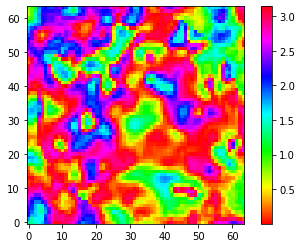

In [90]:
%matplotlib inline
plt.imshow(np.mod(x_hat, np.pi), cmap='hsv')
plt.gca().invert_yaxis()
plt.colorbar()

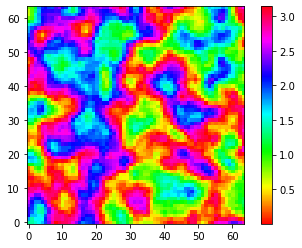

In [91]:
%matplotlib inline
plt.imshow(np.mod(solver_true.diffusion.principle_angle, np.pi), cmap='hsv')
plt.gca().invert_yaxis()
plt.colorbar()

In [78]:
x = solver.diffusion.principle_angle.data.ravel()
cov = solver.diffusion.covariance.data

alpha =  0.1
x_hat = (1.0/alpha)*np.matmul(np.matmul(cov, np.linalg.inv(np.eye(cov.shape[0]) + (1.0/alpha)*cov)), x)

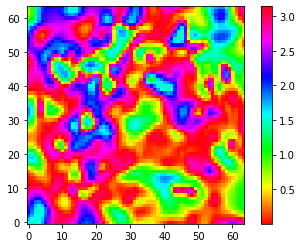

In [79]:
%matplotlib inline
plt.imshow(np.mod(x_hat, np.pi).reshape(64, 64), cmap='hsv')
plt.gca().invert_yaxis()
plt.colorbar()

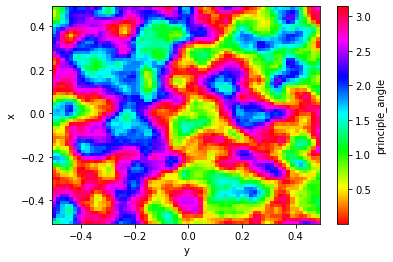

In [10]:
np.mod(solver_true.diffusion.principle_angle, np.pi).plot(cmap='hsv')

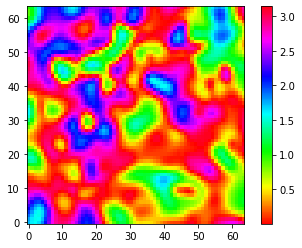

In [69]:
%matplotlib inline
plt.imshow(np.mod(x_hat, np.pi).reshape(64, 64), cmap='hsv')
plt.gca().invert_yaxis()
plt.colorbar()

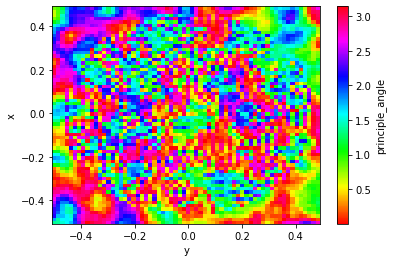

In [62]:
%matplotlib inline
np.mod(solver.diffusion.principle_angle, np.pi).plot(cmap='hsv')